In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import logging
from pathlib import Path

import mat73
import numpy as np
import pandas as pd
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats.saturated_relu import SaturatedReLU
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

nMax = 2
df = None

for i in range(1, nMax):
    participant = f"amap{i:02}"
    PREFIX = f"rats_data/{participant}/*"

    fpath = glob.glob(os.path.join(data.data_path, f"{PREFIX}/*auc_table.csv"))[0]
    temp_df = pd.read_csv(fpath)

    fpath = glob.glob(os.path.join(data.data_path, f"{PREFIX}/*ep_matrix.mat"))[0]
    data_dict = mat73.loadmat(fpath)
    temp_mat = data_dict["ep_sliced"]

    if df is None:
        time = data_dict["t_sliced"]
    else:
        assert((data_dict["t_sliced"] == time).all())

    temp_df["participant"] = participant
    temp_df["segment"] = temp_df.channel2_segment
    temp_df["method"] = temp_df.channel2_laterality

    idx = temp_df.channel1_segment.isna()
    temp_df = temp_df[idx].copy()
    temp_mat = temp_mat[idx, :, :]

    if df is None:
        df = temp_df.copy()
        mat = temp_mat
    else:
        df = pd.concat([df, temp_df], ignore_index=True).copy()
        mat = np.vstack((mat, temp_mat))

df.reset_index(drop=True, inplace=True)

df, encoder_dict = data.build(df)

2023-05-24 14:33:31,032 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-24 14:33:31,039 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-05-24 14:33:31,040 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


#### Plot data

In [5]:
# plot(df, encoder_dict=encoder_dict, mat=mat[:, :, 0], time=time);

#### Initialize model

In [6]:
model = SaturatedReLU(config)

#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-05-24 14:33:31,235 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-24 14:33:31,235 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-24 14:33:31,235 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-24 14:33:31,236 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-24 14:33:31,236 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-24 14:33:31,278 - hb_mep.models.rats.saturated_relu - INFO - Running inference with Saturat

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Diagnostics

In [ ]:
mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
             a[0,0,0]    121.29      4.27    122.01    115.03    127.91   4443.09      1.00
             a[0,0,1]     46.62      1.12     46.82     44.97     48.18   8067.73      1.00
             a[0,0,2]     38.94      4.61     40.06     32.51     44.33   3109.47      1.00
             a[0,0,3]     13.62      4.14     13.85      6.63     19.99   6965.15      1.00
             a[0,0,4]     33.15      2.17     33.40     29.36     36.36   8181.51      1.00
             a[0,1,0]    185.26     49.72    185.27    104.48    266.04   7385.46      1.00
             a[0,1,1]    175.36     54.31    174.98     84.35    262.30  15518.29      1.00
             a[0,1,2]    181.16     67.20    180.79     70.18    292.06  10576.08      1.00
             a[0,1,3]     79.01     50.49     72.59      0.04    147.86  16240.13      1.00
             a[0,1,4]     47.52     19.39     46.96     15.01     78.64  11325.

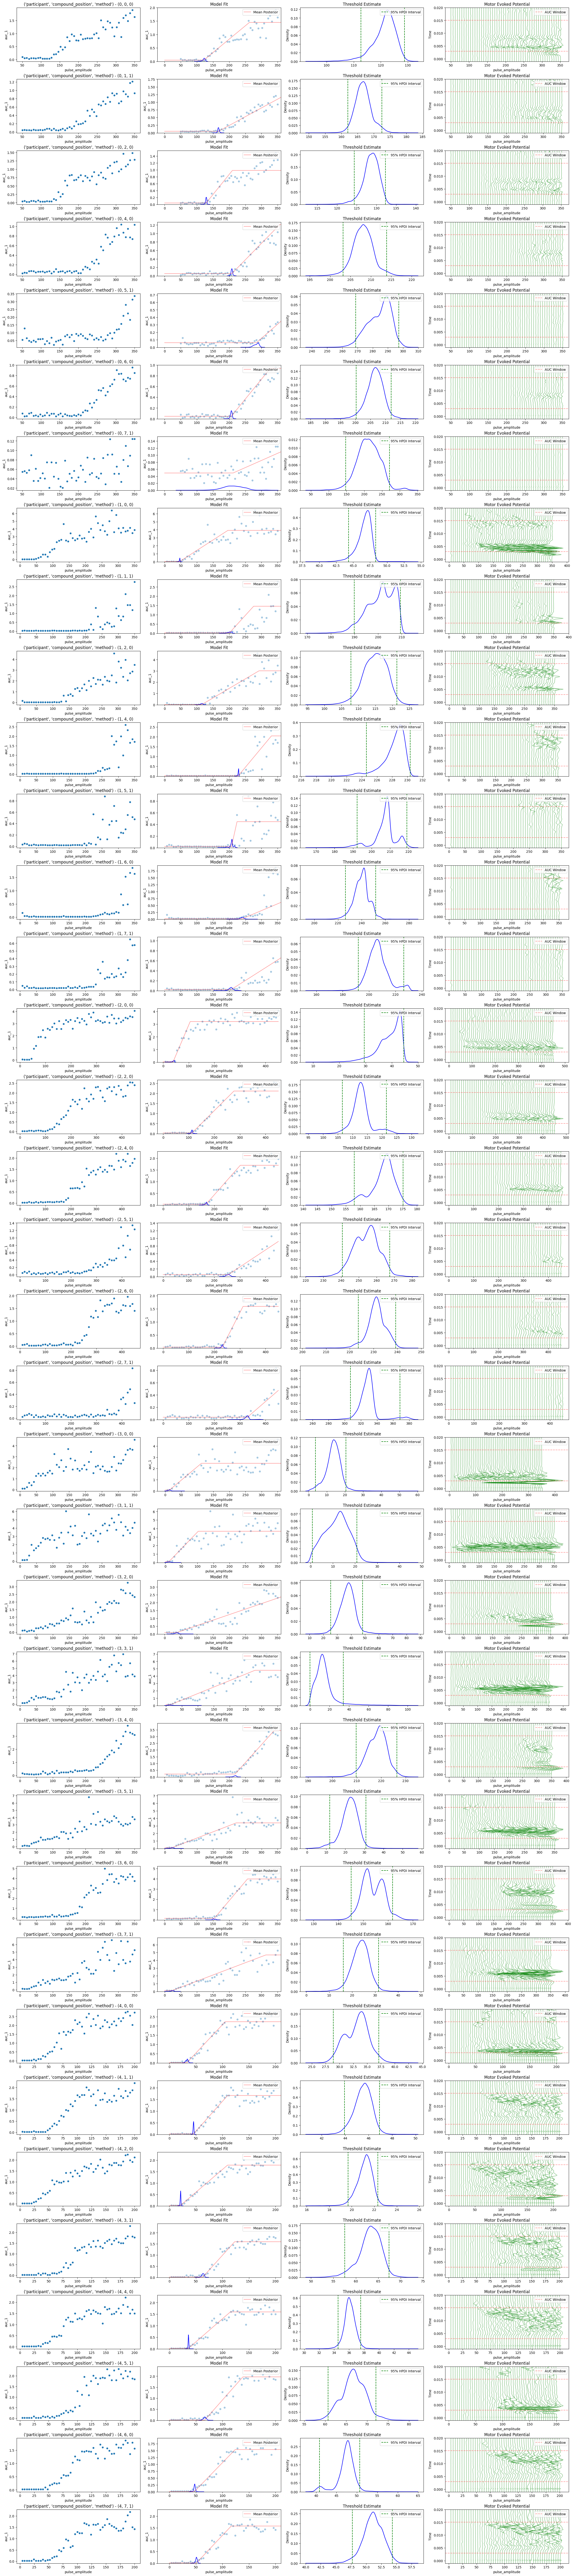

In [ ]:
model.plot(df=df, posterior_samples=posterior_samples, mat=mat[:, :, 0], time=time);